/tmp/ipykernel_2791111/3479149066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='diagnosis', y='brain_volume', palette='Set2')


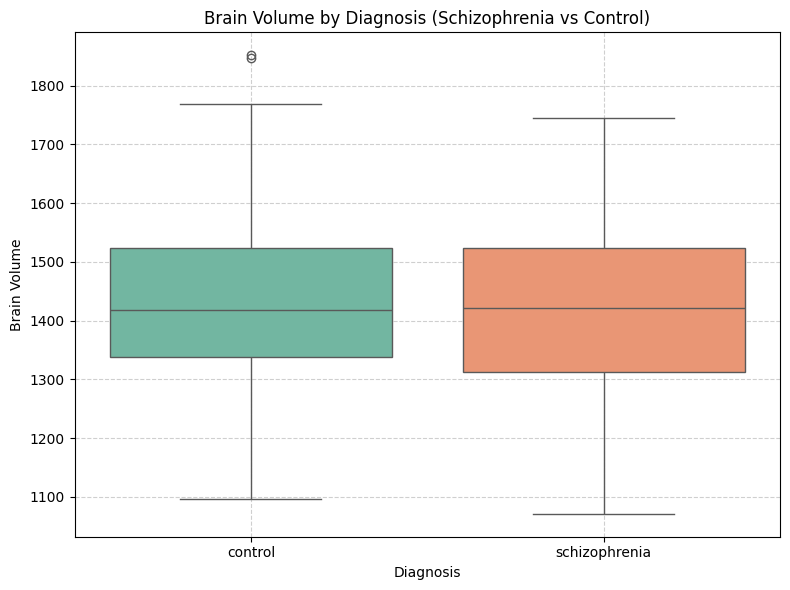

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your participants.csv file
csv_path = "/neurospin/dico/data/deep_folding/current/datasets/schizconnect-vip-prague/participants.csv"

# Load the CSV
df = pd.read_csv(csv_path)

# Convert column names to consistent case if needed
df.columns = [col.strip() for col in df.columns]

# Check if necessary columns exist
required_cols = ['diagnosis','TIV', 'CSF_Vol', 'WM_Vol', 'GM_Vol']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# Compute total brain volume
df['brain_volume'] = df['CSF_Vol'] + df['WM_Vol'] + df['GM_Vol']

# Optional: Clean diagnosis labels if needed
df['diagnosis'] = df['diagnosis'].str.lower().str.strip()

# Filter to only schizophrenia vs control (adjust as needed)
df_filtered = df[df['diagnosis'].isin(['schizophrenia', 'control'])]

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtered, x='diagnosis', y='brain_volume', palette='Set2')
plt.title('Brain Volume by Diagnosis (Schizophrenia vs Control)')
plt.ylabel('Brain Volume')
plt.xlabel('Diagnosis')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [2]:
from scipy.stats import ttest_ind

control_vols = df_filtered[df_filtered["diagnosis"] == "control"]["brain_volume"]
schizo_vols = df_filtered[df_filtered["diagnosis"] == "schizophrenia"]["brain_volume"]

t_stat, p_val = ttest_ind(control_vols, schizo_vols)
print(f"T-test p-value: {p_val}")


T-test p-value: 0.34384918303984924


In [6]:
import pandas as pd

# Load left and right skeleton size files
left = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/skeletons/Lraw_skeleton_size.csv")
right = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/skeletons/Rraw_skeleton_size.csv")

# Rename columns for clarity before merge
left = left.rename(columns={"skeleton_size": "skeleton_size_L"})
right = right.rename(columns={"skeleton_size": "skeleton_size_R"})

# Merge on ID
merged = pd.merge(left, right, on="ID")

# Compute the aggregate skeleton size
merged["skeleton_size_agg"] = merged["skeleton_size_L"] + merged["skeleton_size_R"]

# Save to a new CSV file
merged[["ID", "skeleton_size_agg"]].to_csv("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/skeletons/skeleton_size_agg.csv", index=False)

print(" Merged file saved as 'skeleton_size_agg.csv'")


 Merged file saved as 'skeleton_size_agg.csv'


In [ ]:
from soma import aims
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import multiprocessing
from multiprocessing import Pool


side = 'L'
skeleton_type = 'raw'

list_skeleton_type = ['raw', '2mm']
assert skeleton_type in list_skeleton_type, "skeleton_type not in list_skeleton_type \n Must be 'raw' or '2mm'"

list_subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/participants_sex_age.csv')
list_subjects = list_subjects['Subject'].to_list()

def get_skeleton_size(subject_id):
    """ 
    Count the number of non negative voxels for a subject, for a given hemisphere.

    Args:
        subject_id (str): for instance 'sub-3459925'
        skeleton_type (str): must be 'raw' or '2mm'
        side (str): must be 'L' or 'R'

    Return:
         subject_id, skeleton_size
    """
    if skeleton_type == 'raw':
        # To work with the raw skeleton on the TGCC
        #mm_skeleton_path = f'/home/ad279118/tmp/{subject_id}/ses-2/anat/t1mri/default_acquisition/default_analysis/segmentation'
        #skeleton_path = f"{mm_skeleton_path}/{side}skeleton_{subject_id}.nii.gz"
        
        # To work with the raw skeleton on the /neurospin/dico
        mm_skeleton_path = f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/skeletons/raw/{side}'
        skeleton_path = f"{mm_skeleton_path}/{side}skeleton_generated_{subject_id}.nii.gz"

    elif skeleton_type == '2mm':
        mm_skeleton_path = f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/skeletons/2mm/{side}'
        skeleton_path = f"{mm_skeleton_path}/{side}resampled_skeleton_{subject_id}.nii.gz"

    else:
        raise "skeleton_type not in list_skeleton_type \n Must be 'raw' or '2mm'"

    if os.path.isfile(skeleton_path):
        skeleton = aims.read(skeleton_path)
        skeleton_size = np.count_nonzero((skeleton.np > 0))

        return subject_id, skeleton_size

    else:
        print(f'{skeleton_path} not found')
        return 0, 0
        
list_skeleton_size = []
valid_subjects = []


with Pool(processes=multiprocessing.cpu_count()) as pool:
  for subject_id, skeleton_size in pool.imap(get_skeleton_size, list_subjects):
    if skeleton_size!=0:
      list_skeleton_size.append(skeleton_size)
      valid_subjects.append(subject_id)
  
print(len(valid_subjects), len(list_skeleton_size))
df_skeleton = pd.DataFrame({"ID": valid_subjects, "skeleton_size": list_skeleton_size})

plt.figure(figsize=(12,4))
plt.hist(df_skeleton["skeleton_size"], bins=180)
plt.xlabel('Nb of non zero voxel')
plt.ylabel('Frequency')
plt.show()

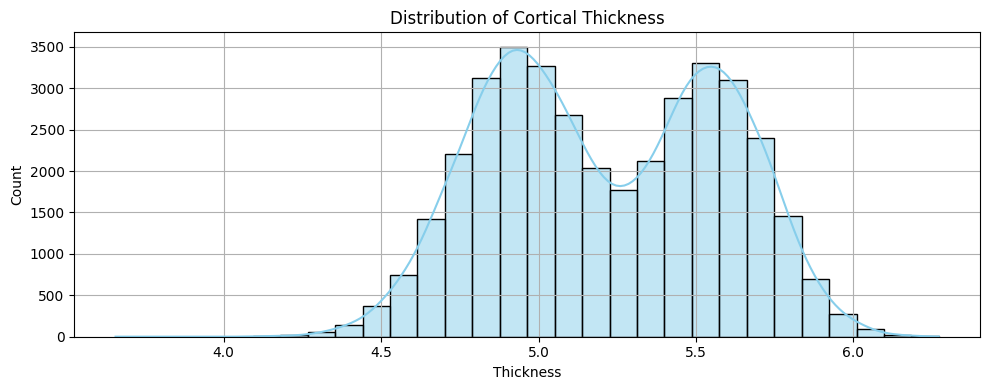

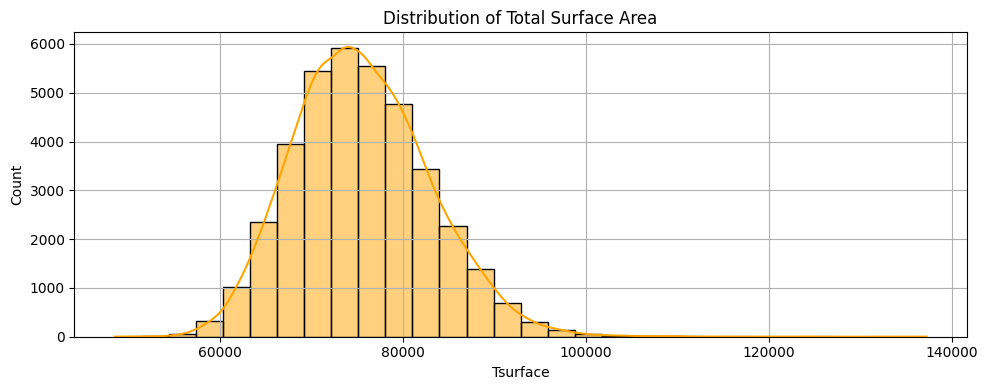

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV file
df = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/surface_thickness.csv")

# Optional: clean column names if needed
df.columns = df.columns.str.strip()

# Convert to numeric in case there are formatting issues
df["Thickness"] = pd.to_numeric(df["Thikness"], errors="coerce")
df["Tsurface"] = pd.to_numeric(df["Tsurface"], errors="coerce")

# Drop any rows with NaNs
df.dropna(subset=["Thickness", "Tsurface"], inplace=True)

# Plot Thickness distribution
plt.figure(figsize=(10, 4))
sns.histplot(df["Thickness"], kde=True, color="skyblue", bins=30)
plt.title("Distribution of Cortical Thickness")
plt.xlabel("Thickness")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Tsurface distribution
plt.figure(figsize=(10, 4))
sns.histplot(df["Tsurface"], kde=True, color="orange", bins=30)
plt.title("Distribution of Total Surface Area")
plt.xlabel("Tsurface")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# === Paths ===
main_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/participants_sex_age_volumes_normalized.csv"
surface_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/surface_thickness.csv"
output_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv"

# === Load files ===
df_main = pd.read_csv(main_file)
df_surface = pd.read_csv(surface_file)

# === Normalize IDs ===
df_main['participant_id'] = df_main['participant_id'].str.replace('sub-', '').str.zfill(6)
df_surface['ID'] = df_surface['ID'].str.replace('sub-', '').str.zfill(6)

# === Merge based on ID ===
merged = df_main.merge(df_surface.rename(columns={'ID': 'participant_id'}), on='participant_id', how='left')

# === Save the new file ===
merged.to_csv(output_file, index=False)
print(f"Merged file saved to: {output_file}")


✅ Merged file saved to: /neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv


/tmp/ipykernel_153562/1284738425.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="sex", y="thickness", inner="box", palette="Set2")


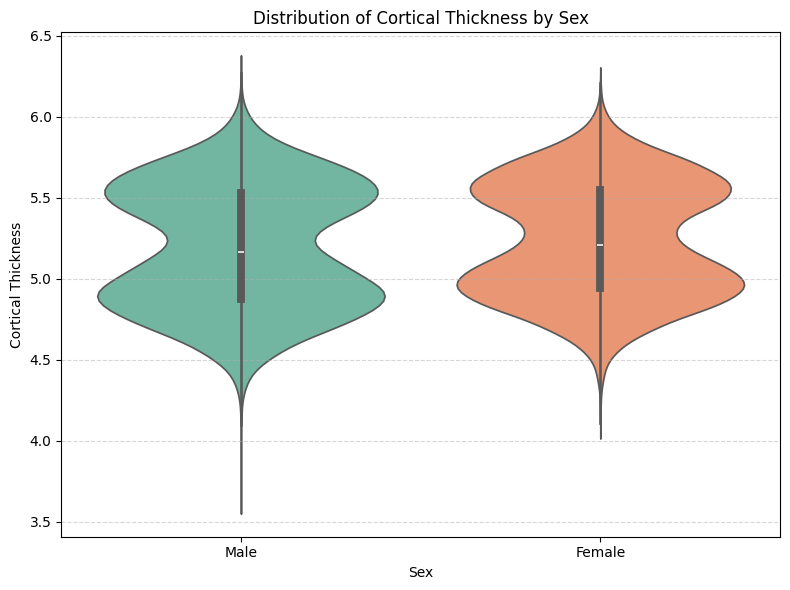

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your local file
df = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv")

# Clean columns
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={'thikness': 'thickness'}, inplace=True)

# Convert sex to readable labels if needed
df['sex'] = df['sex'].map({0: 'Female', 1: 'Male'})

# Plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="sex", y="thickness", inner="box", palette="Set2")
plt.title("Distribution of Cortical Thickness by Sex")
plt.xlabel("Sex")
plt.ylabel("Cortical Thickness")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


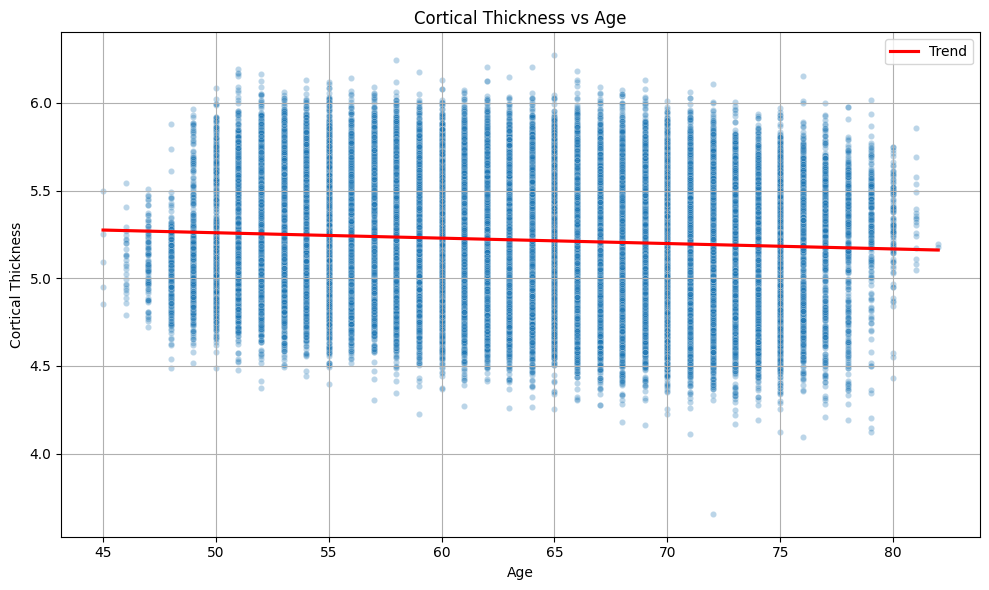

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv")

# Clean column names
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={'thikness': 'thickness'}, inplace=True)

# Plot: Thickness vs Age
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="age", y="thickness", alpha=0.3, s=20)
sns.regplot(data=df, x="age", y="thickness", scatter=False, color='red', label="Trend")

plt.title("Cortical Thickness vs Age")
plt.xlabel("Age")
plt.ylabel("Cortical Thickness")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


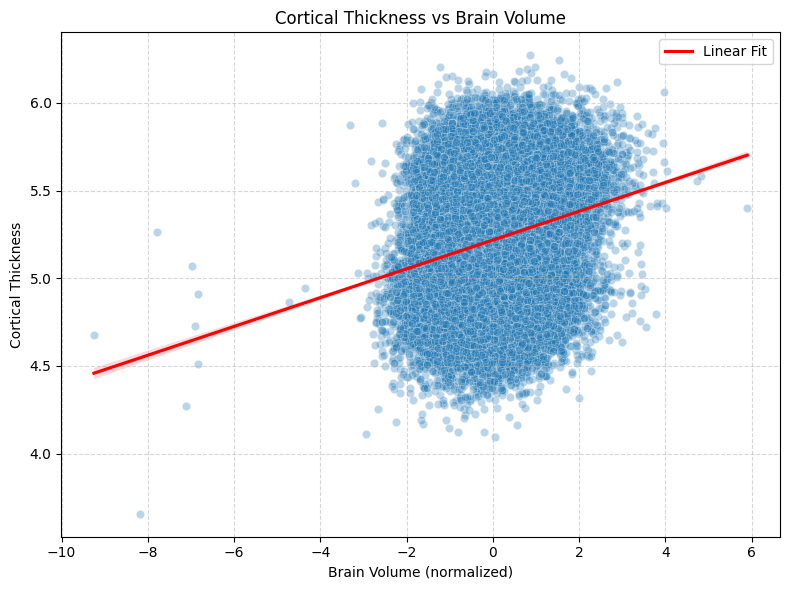

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv")

# Clean and rename columns
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={'thikness': 'thickness'}, inplace=True)

# Drop missing values for safety
df = df.dropna(subset=["thickness", "volume"])

# Plot thickness vs volume
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="volume", y="thickness", alpha=0.3)
sns.regplot(data=df, x="volume", y="thickness", scatter=False, color="red", label="Linear Fit")

plt.title("Cortical Thickness vs Brain Volume")
plt.xlabel("Brain Volume (normalized)")
plt.ylabel("Cortical Thickness")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


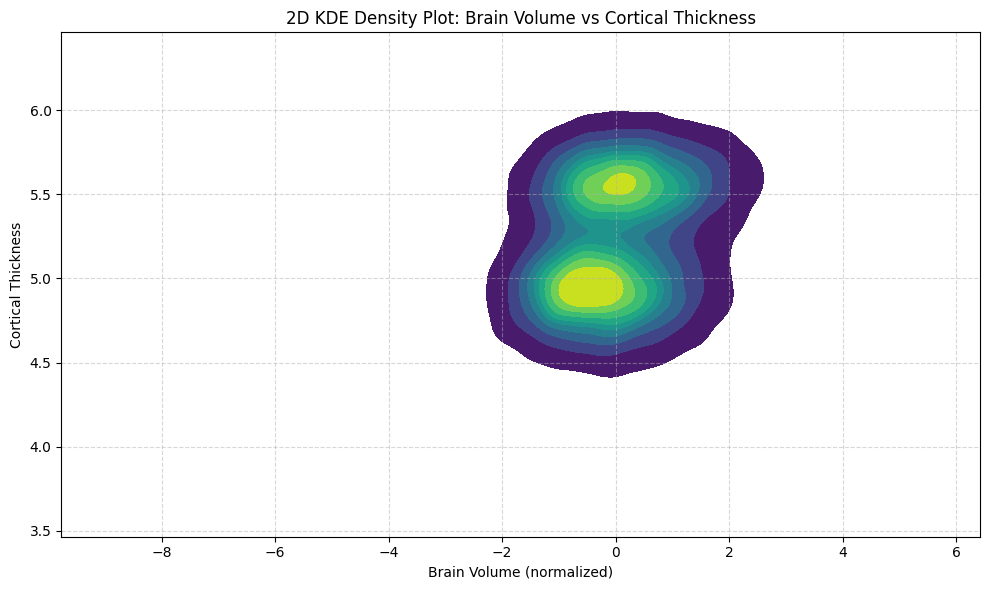

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv")
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={"thikness": "thickness"}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df,
    x="volume", y="thickness",
    fill=True, cmap="viridis", thresh=0.05
)
plt.title("2D KDE Density Plot: Brain Volume vs Cortical Thickness")
plt.xlabel("Brain Volume (normalized)")
plt.ylabel("Cortical Thickness")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


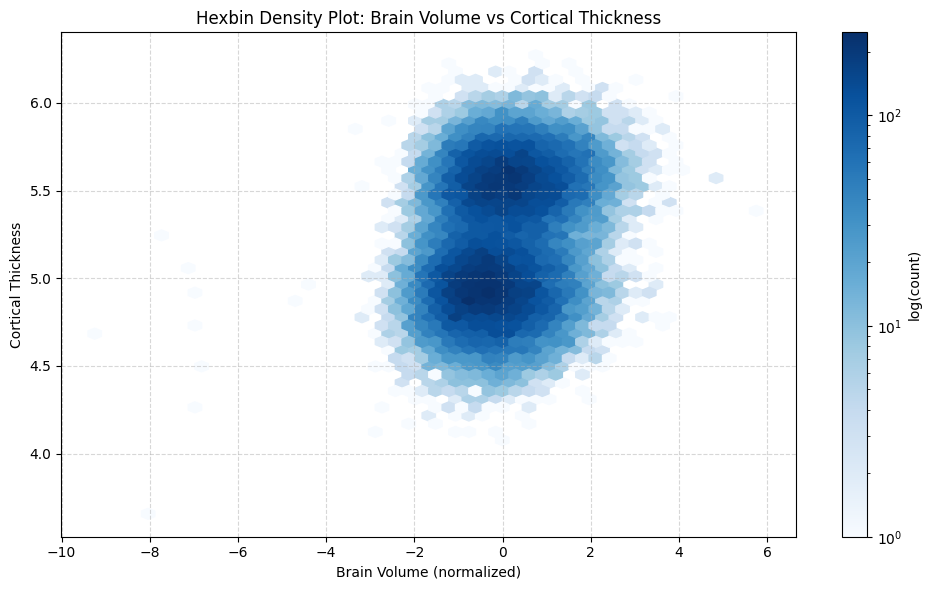

In [10]:
plt.figure(figsize=(10, 6))
plt.hexbin(df["volume"], df["thickness"], gridsize=50, cmap='Blues', bins='log')
plt.colorbar(label='log(count)')
plt.xlabel("Brain Volume (normalized)")
plt.ylabel("Cortical Thickness")
plt.title("Hexbin Density Plot: Brain Volume vs Cortical Thickness")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


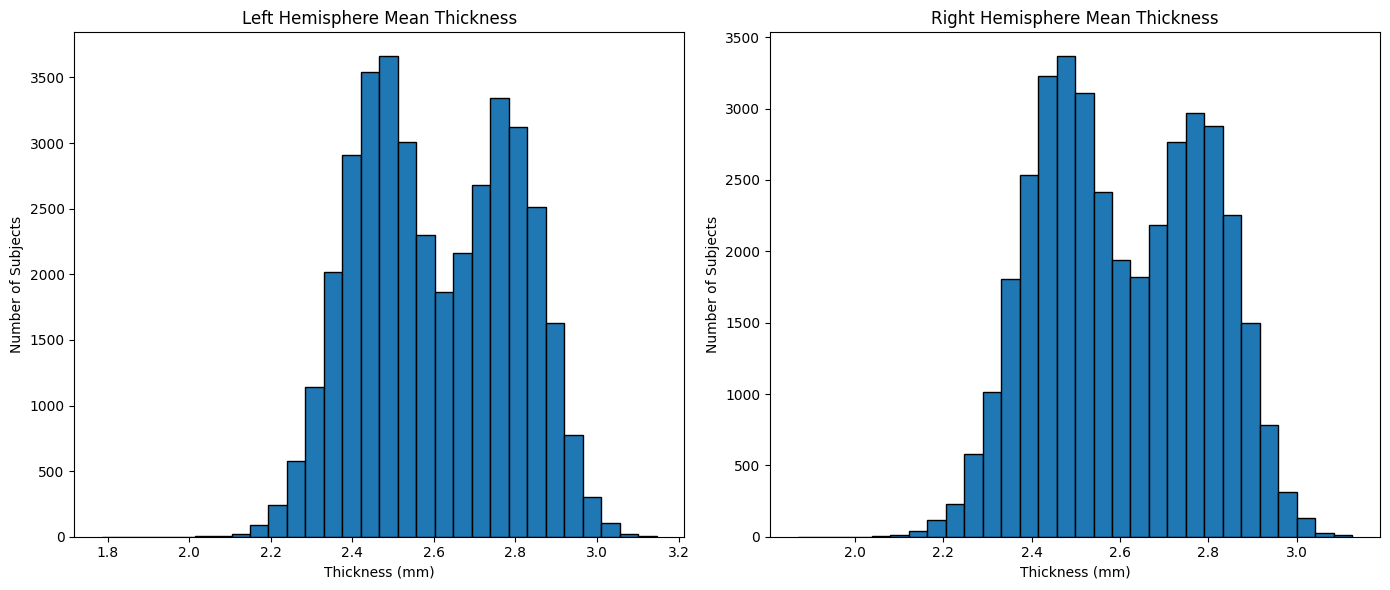

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Define file paths
rh_file = "/neurospin/dico/data/human/UKBioBank/derivatives/ns_freesurfer-summary/rh.a2009s.thickness.txt"
lh_file = "/neurospin/dico/data/human/UKBioBank/derivatives/ns_freesurfer-summary/lh.a2009s.thickness.txt"

# Load the data
rh_df = pd.read_csv(rh_file, sep='\t')  # or sep=' ' if it's space-separated
lh_df = pd.read_csv(lh_file, sep='\t')

# Extract the relevant columns
rh_thickness = rh_df["rh_MeanThickness_thickness"]
lh_thickness = lh_df["lh_MeanThickness_thickness"]

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(lh_thickness, bins=30, edgecolor='black')
plt.title('Left Hemisphere Mean Thickness')
plt.xlabel('Thickness (mm)')
plt.ylabel('Number of Subjects')

plt.subplot(1, 2, 2)
plt.hist(rh_thickness, bins=30, edgecolor='black')
plt.title('Right Hemisphere Mean Thickness')
plt.xlabel('Thickness (mm)')
plt.ylabel('Number of Subjects')

plt.tight_layout()
plt.show()


Median age used for splitting: 64.00 years


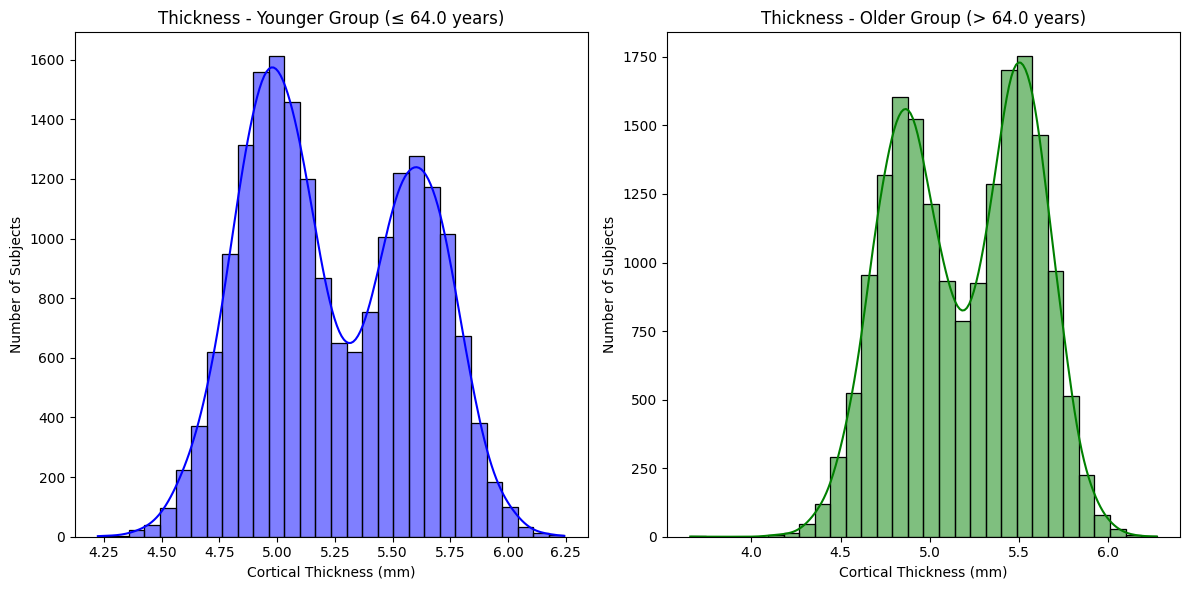

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv")

# Clean column names
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={'thikness': 'thickness'}, inplace=True)

# Compute median age
median_age = df["age"].median()
print(f"Median age used for splitting: {median_age:.2f} years")

# Split into two groups
younger_group = df[df["age"] <= median_age]
older_group = df[df["age"] > median_age]

# Plot histograms
plt.figure(figsize=(12, 6))

# Younger group
plt.subplot(1, 2, 1)
sns.histplot(younger_group["thickness"], bins=30, kde=True, color="blue")
plt.title(f"Thickness - Younger Group (≤ {median_age:.1f} years)")
plt.xlabel("Cortical Thickness (mm)")
plt.ylabel("Number of Subjects")

# Older group
plt.subplot(1, 2, 2)
sns.histplot(older_group["thickness"], bins=30, kde=True, color="green")
plt.title(f"Thickness - Older Group (> {median_age:.1f} years)")
plt.xlabel("Cortical Thickness (mm)")
plt.ylabel("Number of Subjects")

plt.tight_layout()
plt.show()



Matched subset size: 21039
Remaining subjects: 21747


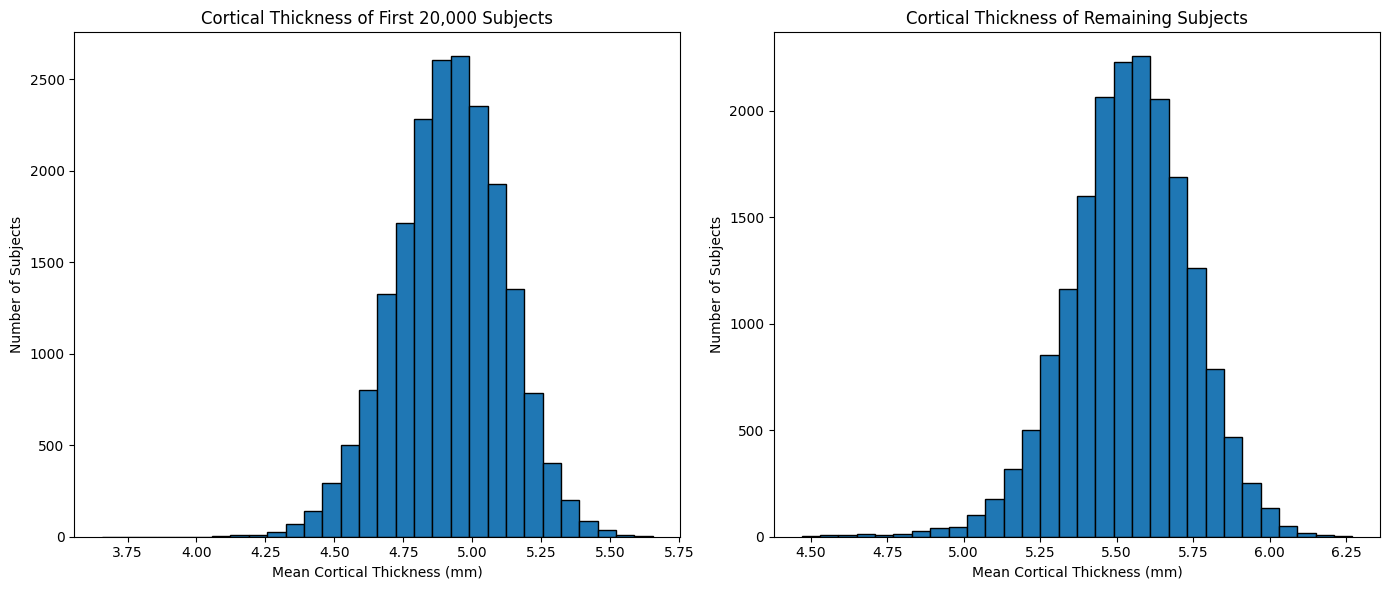

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- File paths ---
volume_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv"  
subset_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/S.C.-sylv./mask/Rskeleton_subject.csv"

# --- Load and normalize subject list ---
subset_df = pd.read_csv(subset_file)
subset_df.rename(columns={"Subject": "participant_id"}, inplace=True)
# Remove "sub-" prefix and convert to int
subset_df["participant_id"] = subset_df["participant_id"].str.replace("sub-", "").astype(int)

subset_subjects = set(subset_df["participant_id"])

# --- Load volume data ---
volume_df = pd.read_csv(volume_file)

# --- Use Thikness column instead of volume ---
thickness_col = "Thikness"  # Use exact name from your file
if thickness_col not in volume_df.columns:
    print("Available columns:", volume_df.columns)
    raise ValueError(f"Expected thickness column '{thickness_col}' in volume_file")

# --- Split into two groups ---
subset_thickness = volume_df[volume_df["participant_id"].isin(subset_subjects)]
rest_thickness = volume_df[~volume_df["participant_id"].isin(subset_subjects)]

print(f"Matched subset size: {len(subset_thickness)}")
print(f"Remaining subjects: {len(rest_thickness)}")

# --- Plot histograms ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(subset_thickness[thickness_col], bins=30, edgecolor='black')
plt.title('Cortical Thickness of First 20,000 Subjects')
plt.xlabel('Mean Cortical Thickness (mm)')
plt.ylabel('Number of Subjects')

plt.subplot(1, 2, 2)
plt.hist(rest_thickness[thickness_col], bins=30, edgecolor='black')
plt.title('Cortical Thickness of Remaining Subjects')
plt.xlabel('Mean Cortical Thickness (mm)')
plt.ylabel('Number of Subjects')

plt.tight_layout()
plt.show()


Matched subset size: 19572
Remaining subjects: 18145


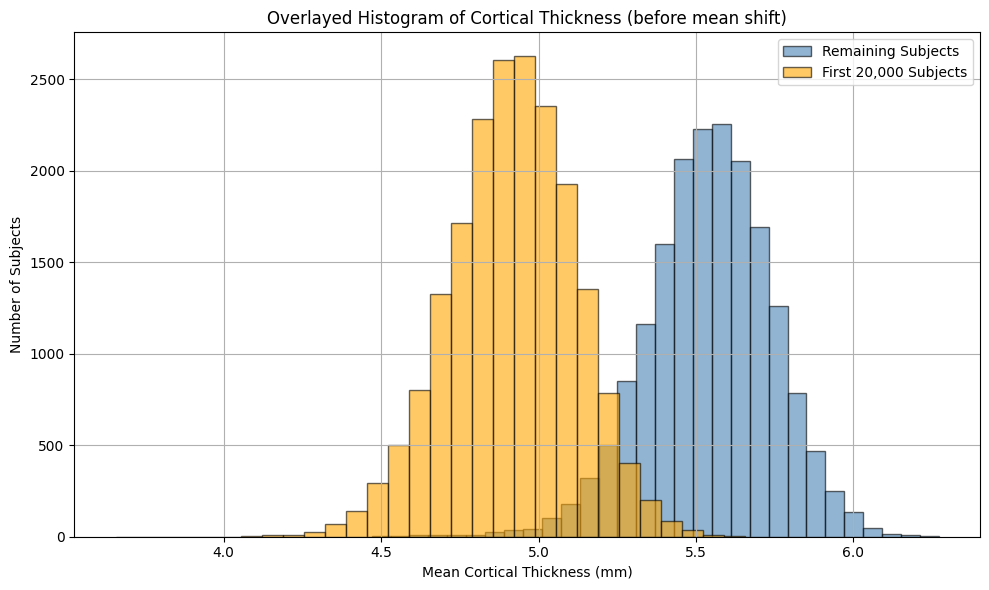

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# --- File paths ---
volume_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv"  
subset_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/S.C.-sylv./mask/Rskeleton_subject.csv"

# --- Load and normalize subject list ---
subset_df = pd.read_csv(subset_file)
subset_df.rename(columns={"Subject": "participant_id"}, inplace=True)
# Remove "sub-" prefix and convert to int
subset_df["participant_id"] = subset_df["participant_id"].str.replace("sub-", "").astype(int)

subset_subjects = set(subset_df["participant_id"])

# --- Load volume data ---
volume_df = pd.read_csv(volume_file)

# --- Use Thikness column ---
thickness_col = "Thikness"
if thickness_col not in volume_df.columns:
    print("Available columns:", volume_df.columns)
    raise ValueError(f"Expected thickness column '{thickness_col}' in volume_file")

# --- Split data ---
subset_thickness = volume_df[volume_df["participant_id"].isin(subset_subjects)][thickness_col].dropna()
rest_thickness = volume_df[~volume_df["participant_id"].isin(subset_subjects)][thickness_col].dropna()

print(f"Matched subset size: {len(subset_thickness)}")
print(f"Remaining subjects: {len(rest_thickness)}")

# --- Plot both on the same histogram ---
plt.figure(figsize=(10, 6))

plt.hist(rest_thickness, bins=30, alpha=0.6, label="Remaining Subjects", color='steelblue', edgecolor='black')
plt.hist(subset_thickness, bins=30, alpha=0.6, label="First 20,000 Subjects", color='orange', edgecolor='black')

plt.title("Overlayed Histogram of Cortical Thickness (before mean shift)")
plt.xlabel("Mean Cortical Thickness (mm)")
plt.ylabel("Number of Subjects")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Mean shift applied: -0.6250 mm


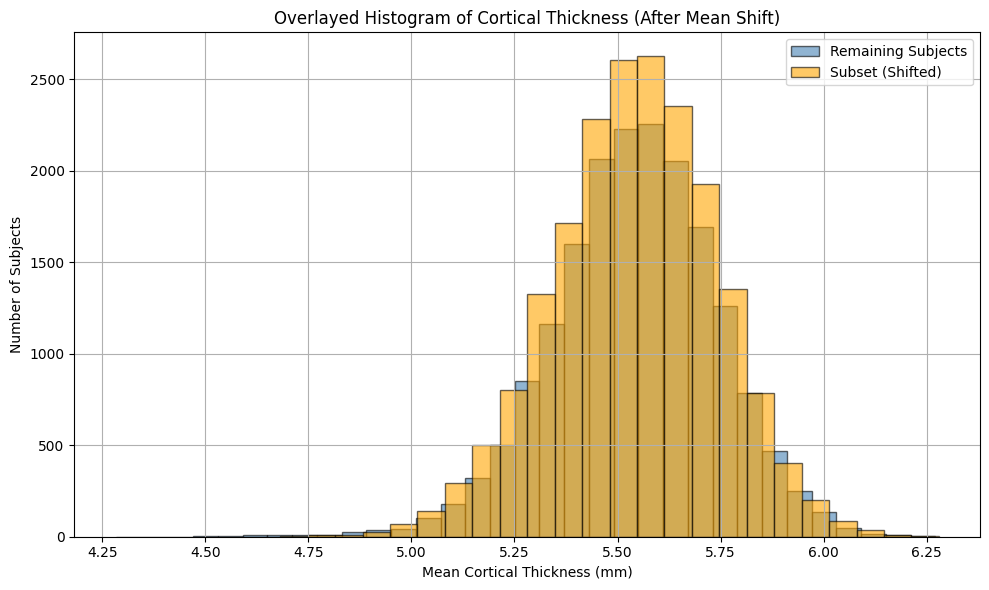

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# --- File paths ---
volume_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv"  
subset_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/S.C.-sylv./mask/Rskeleton_subject.csv"

# --- Load and normalize subject list ---
subset_df = pd.read_csv(subset_file)
subset_df.rename(columns={"Subject": "participant_id"}, inplace=True)
subset_df["participant_id"] = subset_df["participant_id"].str.replace("sub-", "").astype(int)
subset_subjects = set(subset_df["participant_id"])

# --- Load volume data ---
volume_df = pd.read_csv(volume_file)

# --- Use Thikness column ---
thickness_col = "Thikness"
if thickness_col not in volume_df.columns:
    print("Available columns:", volume_df.columns)
    raise ValueError(f"Expected thickness column '{thickness_col}' in volume_file")

# --- Split data ---
subset_thickness = volume_df[volume_df["participant_id"].isin(subset_subjects)][thickness_col].dropna()
rest_thickness = volume_df[~volume_df["participant_id"].isin(subset_subjects)][thickness_col].dropna()

# --- Compute the shift (difference in means) ---
mean_diff = subset_thickness.mean() - rest_thickness.mean()
print(f"Mean shift applied: {mean_diff:.4f} mm")

# --- Apply the shift to subset data ---
subset_thickness_shifted = subset_thickness - mean_diff

# --- Plot both distributions after shift ---
plt.figure(figsize=(10, 6))

plt.hist(rest_thickness, bins=30, alpha=0.6, label="Remaining Subjects", color='steelblue', edgecolor='black')
plt.hist(subset_thickness_shifted, bins=30, alpha=0.6, label="Subset (Shifted)", color='orange', edgecolor='black')

plt.title("Overlayed Histogram of Cortical Thickness (After Mean Shift)")
plt.xlabel("Mean Cortical Thickness (mm)")
plt.ylabel("Number of Subjects")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Mean shift applied: -0.6250 mm


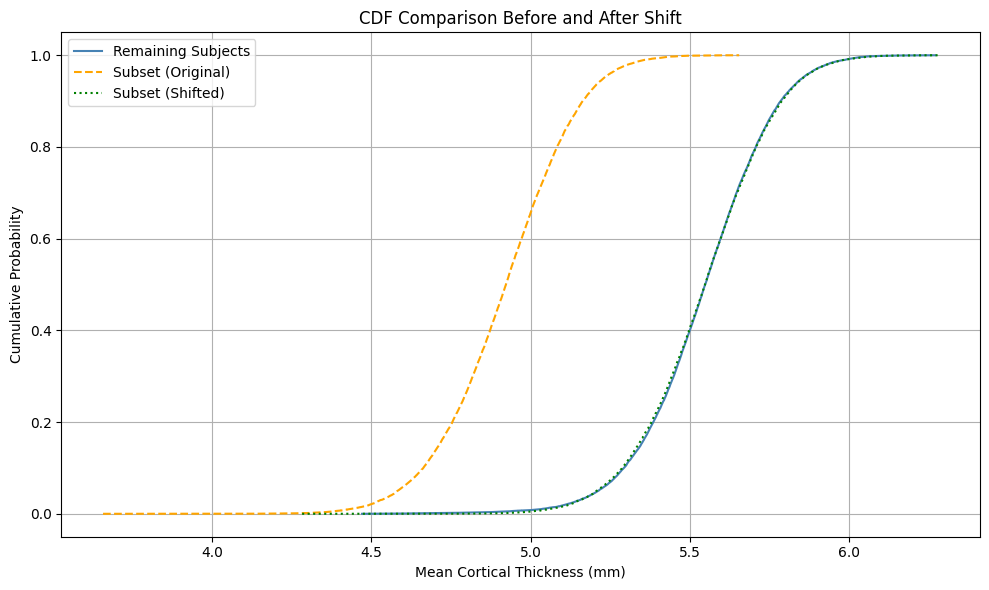

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- File paths ---
volume_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv"  
subset_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/S.C.-sylv./mask/Rskeleton_subject.csv"

# --- Load and normalize subject list ---
subset_df = pd.read_csv(subset_file)
subset_df.rename(columns={"Subject": "participant_id"}, inplace=True)
subset_df["participant_id"] = subset_df["participant_id"].str.replace("sub-", "").astype(int)
subset_subjects = set(subset_df["participant_id"])

# --- Load volume data ---
volume_df = pd.read_csv(volume_file)
thickness_col = "Thikness"
if thickness_col not in volume_df.columns:
    raise ValueError(f"Expected column '{thickness_col}' in volume_file")

# --- Split data ---
subset_thickness = volume_df[volume_df["participant_id"].isin(subset_subjects)][thickness_col].dropna()
rest_thickness = volume_df[~volume_df["participant_id"].isin(subset_subjects)][thickness_col].dropna()

# --- Compute shift ---
mean_diff = subset_thickness.mean() - rest_thickness.mean()
subset_thickness_shifted = subset_thickness - mean_diff
print(f"Mean shift applied: {mean_diff:.4f} mm")

# --- Helper: compute empirical CDF ---
def compute_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.linspace(0, 1, len(sorted_data))
    return sorted_data, cdf

# --- Compute CDFs ---
x_rest, cdf_rest = compute_cdf(rest_thickness)
x_orig, cdf_orig = compute_cdf(subset_thickness)
x_shifted, cdf_shifted = compute_cdf(subset_thickness_shifted)

# --- Plot ---
plt.figure(figsize=(10, 6))

plt.plot(x_rest, cdf_rest, label="Remaining Subjects", color='steelblue')
plt.plot(x_orig, cdf_orig, label="Subset (Original)", linestyle='--', color='orange')
plt.plot(x_shifted, cdf_shifted, label="Subset (Shifted)", linestyle=':', color='green')

plt.title("CDF Comparison Before and After Shift")
plt.xlabel("Mean Cortical Thickness (mm)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
import pandas as pd

# Load the file without touching the index or renaming anything
df = pd.read_csv("/neurospin/dico/data/human/UKBioBank/derivatives/ns_freesurfer-summary/lh.a2009s.thickness.txt", sep="\t")

# Show first few entries of the suspected subject ID column
print("Sample values from 'lh.aparc.a2009s.thickness':")
print(df["lh.aparc.a2009s.thickness"].head())


Sample values from 'lh.aparc.a2009s.thickness':
0    sub-1000021
1    sub-1000325
2    sub-1000458
3    sub-1000575
4    sub-1000606
Name: lh.aparc.a2009s.thickness, dtype: object


In [28]:
import pandas as pd

# --- File paths ---
lh_file = "/neurospin/dico/data/human/UKBioBank/derivatives/ns_freesurfer-summary/lh.a2009s.thickness.txt"
rh_file = "/neurospin/dico/data/human/UKBioBank/derivatives/ns_freesurfer-summary/rh.a2009s.thickness.txt"
subset_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/S.C.-sylv./mask/Rskeleton_subject.csv"
main_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv"

# --- Load subject list ---
subset_df = pd.read_csv(subset_file)
subset_df.rename(columns={"Subject": "participant_id"}, inplace=True)
subset_df["participant_id"] = subset_df["participant_id"].str.replace("sub-", "").astype(int)
subset_subjects = set(subset_df["participant_id"])

# --- Load thickness files ---
lh_df = pd.read_csv(lh_file, sep="\t")
rh_df = pd.read_csv(rh_file, sep="\t")

# Extract subject IDs and normalize for matching
lh_df["participant_id"] = lh_df["lh.aparc.a2009s.thickness"].str.replace("sub-", "").astype(int)
rh_df["participant_id"] = rh_df["rh.aparc.a2009s.thickness"].str.replace("sub-", "").astype(int)

# --- Use correct column names ---
lh_col = "lh_MeanThickness_thickness"
rh_col = "rh_MeanThickness_thickness"

# --- Apply mean shift ---
def apply_mean_shift(df, thickness_col, subset_ids):
    subset = df[df["participant_id"].isin(subset_ids)][thickness_col]
    rest = df[~df["participant_id"].isin(subset_ids)][thickness_col]
    mean_diff = subset.mean() - rest.mean()
    print(f"Shift applied to {thickness_col}: {mean_diff:.4f} mm")
    df.loc[df["participant_id"].isin(subset_ids), thickness_col] = subset - mean_diff
    return df, mean_diff

lh_df_shifted, lh_shift = apply_mean_shift(lh_df.copy(), lh_col, subset_subjects)
rh_df_shifted, rh_shift = apply_mean_shift(rh_df.copy(), rh_col, subset_subjects)

# --- Save shifted lh/rh thickness files ---
lh_df_shifted.to_csv(lh_file.replace(".txt", "2.txt"), sep="\t", index=False)
rh_df_shifted.to_csv(rh_file.replace(".txt", "2.txt"), sep="\t", index=False)

# --- Compute mean thickness per subject ---
merged_df = lh_df_shifted[["participant_id", lh_col]].merge(
    rh_df_shifted[["participant_id", rh_col]], on="participant_id"
)
merged_df["mean_thickness"] = (merged_df[lh_col] + merged_df[rh_col]) / 2

# --- Merge into main Total_UKB40.csv ---
main_df = pd.read_csv(main_file)
updated_df = pd.merge(main_df, merged_df[["participant_id", "mean_thickness"]], on="participant_id", how="left")

# --- Save updated main file ---
updated_df.to_csv(main_file, index=False)
print(f"mean_thickness added and saved into: {main_file}")


Shift applied to lh_MeanThickness_thickness: -0.3102 mm
Shift applied to rh_MeanThickness_thickness: -0.3067 mm
mean_thickness added and saved into: /neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv


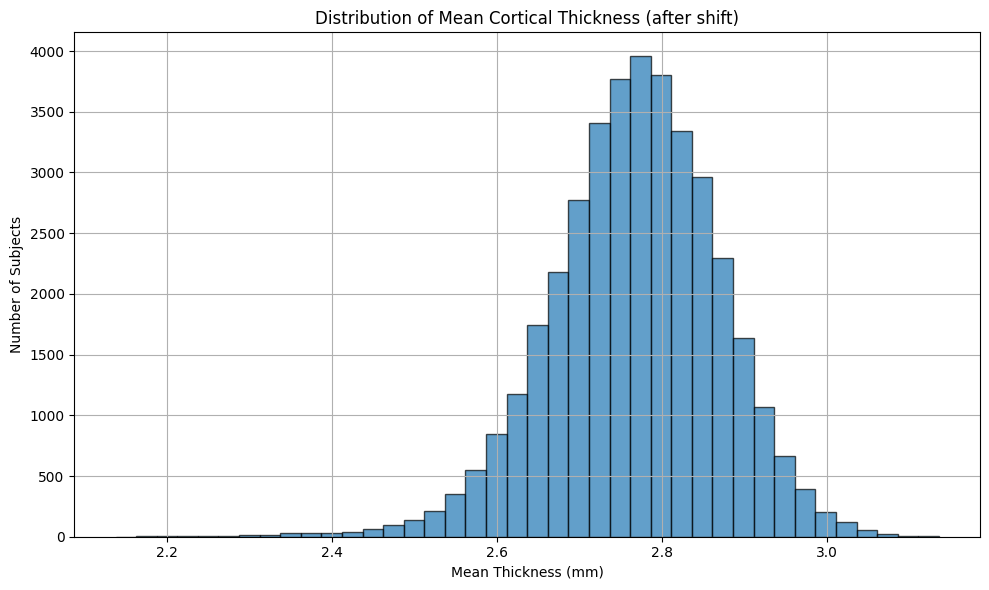

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load the updated file ---
file_path = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv"
df = pd.read_csv(file_path)

# --- Check that 'mean_thickness' column exists ---
if "mean_thickness_x" not in df.columns:
    raise ValueError(" Column 'mean_thickness' not found in the file.")

# --- Plot histogram ---
plt.figure(figsize=(10, 6))
plt.hist(df["mean_thickness_x"].dropna(), bins=40, edgecolor='black', alpha=0.7)
plt.title("Distribution of Mean Cortical Thickness (after shift)")
plt.xlabel("Mean Thickness (mm)")
plt.ylabel("Number of Subjects")
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# Paths to your files
main_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/Total_UKB40.csv" 
volume_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/participants_sex_age_volumes.csv"

# Load CSVs
df_main = pd.read_csv(main_file)
df_vol = pd.read_csv(volume_file)

# Format participant_id to match 'sub-XXXXX' format
df_main["participant_id"] = df_main["participant_id"].apply(lambda x: f"sub-{int(x)}")
df_vol["participant_id"] = df_vol["participant_id"].astype(str)

# Merge on participant_id to get the real volume values
df_merged = df_main.merge(df_vol[["participant_id", "volume"]], on="participant_id", how="left", suffixes=('', '_normalized'))

# Rename the volume column
df_merged = df_merged.rename(columns={"volume_normalized": "volume_normalized"})

# Drop the old volume column and rename the new one
df_merged = df_merged.drop(columns=["volume"])
df_merged = df_merged.rename(columns={"volume_normalized": "volume"})

# Drop mean_thickness_y and rename mean_thickness_x
df_merged = df_merged.drop(columns=["mean_thickness_y"])
df_merged = df_merged.rename(columns={"mean_thickness_x": "mean_thickness"})

# Save the new file
df_merged.to_csv("cleaned_participants.csv", index=False)
print("✅ File saved as 'cleaned_participants.csv'")


✅ File saved as 'cleaned_participants.csv'


In [3]:
import pandas as pd

# Load the cleaned file from the previous step
df = pd.read_csv("cleaned_participants.csv")

# Drop rows with missing values in 'volume' or 'mean_thickness'
df_cleaned = df.dropna(subset=["volume", "mean_thickness"])

# Save the final cleaned version
df_cleaned.to_csv("cleaned_participants2.csv", index=False)
print("✅ Final file saved as 'final_participants.csv' with missing values dropped.")


✅ Final file saved as 'final_participants.csv' with missing values dropped.
